In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 39.5 MB/s eta 0:00:00


In [ ]:
save_path = '/content/drive/MyDrive/'
save_path1 = '/content/drive/MyDrive/'

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import vgg16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!unzip /content/drive/MyDrive/NewDataset.zip

Archive:  /content/drive/MyDrive/NewDataset.zip
  inflating: NewData/TestLabels.npy  
  inflating: NewData/ValLabels.npy   
  inflating: NewData/TrainLabels.npy  
  inflating: NewData/ValData.npy     
  inflating: NewData/TestData.npy    
  inflating: NewData/TrainData.npy   


In [ ]:
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/NewData/TrainData.npy")
y_train = np.load("/content/NewData/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/NewData/ValData.npy")
y_val = np.load("/content/NewData/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/NewData/TestData.npy")
y_test = np.load("/content/NewData/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

data_augmentation.layers[0].adapt(x_train)

In [ ]:
img_heigth, img_width = 110,110
input_shape = (img_heigth, img_width, 3)
num_classes = 5

In [ ]:
def create_encoder():
    vgg16 = keras.applications.ResNet50(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = vgg16(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="resnet50-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.0001
batch_size = 32
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "resnet50-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     7         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,719
Trainable params: 23,534,592
Non-trainable params: 53,127
_________________________________________________________________


In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="resnet50-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [ ]:
filters = 32
kernel_size = (3, 3)


In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    
    # Add a convolutional layer
    features = layers.Conv2D(filters, kernel_size, activation='relu')(features)
    
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="resnet50-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr


In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (110,110, 3)

LR = .001
shuffler = 1024

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 116, 116, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 55, 55, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 55, 55, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()



In [ ]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

  0%|          | 0/284 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f3431442d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 277, in close
    if self.disable:
AttributeError: 'tqdm_notebook' object has no attribute 'disable'


Epoch 1, Training Loss: nan, Test Loss: nan


  0%|          | 0/284 [00:00<?, ?it/s]

Epoch 2, Training Loss: nan, Test Loss: nan


  0%|          | 0/284 [00:00<?, ?it/s]

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/baseline_model_resnet50.hdf5', 
                               monitor='sparse_categorical_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs,callbacks=callbacks)

In [ ]:
resnet50_base_trainloss_dict = {}
resnet50_base_valloss_dict = {}

In [ ]:
import pickle

with open('/content/drive/MyDrive/resnet50_base_train_loss.pkl', 'wb') as file:
    pickle.dump(resnet50_base_trainloss_dict, file)

with open('/content/drive/MyDrive/resnet50__base_val_loss.pkl', 'wb') as file:
    pickle.dump(resnet50_base_valloss_dict, file)

In [ ]:
pred = classifier.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#ax.xaxis.set_ticklabels(x_test.class_indices)
#ax.yaxis.set_ticklabels(y_test)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report_base = classification_report(y_test, y_pred, output_dict=True)
df12 = pd.DataFrame(report_base).transpose()
df12

In [ ]:
from tensorflow.keras.models import load_model
baseline_VGG16=load_model(save_path + 'Contrastive_Baseline_resnet50.h5')


In [ ]:
accuracy = baseline_VGG16.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
classifier=baseline_VGG16
y_predict = np.argmax(classifier.predict(x_test), axis=-1)

In [ ]:
cancer_classes=np.unique(y_test)

pred = baseline_VGG16.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(cancer_classes)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report_base = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df12 = pd.DataFrame(report_base).transpose()
df12

# N-pair loss

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="resnet50_-encoder_with_projection-head"
    )
    return model

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)


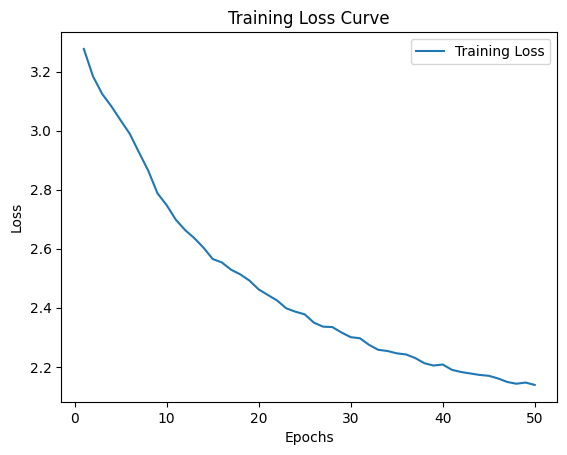

In [ ]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
encoder_with_projection_head.save(save_path + 'Contrastive_npairloss_resnet50.h5')
encoder_with_projection_head.save_weights(save_path1 + "Weights_Contrastive_npairloss_resnet50.h5")

In [ ]:
resnet50_npair_trainloss_dict = {}
resnet50_npair_valloss_dict = {}

In [ ]:
import pickle

with open('/content/drive/MyDrive/resnet50_npair_trainloss_dict.pkl', 'wb') as file:
    pickle.dump(resnet50_npair_trainloss_dict, file)

with open('/content/drive/MyDrive/resnet50_npair_valloss_dict.pkl', 'wb') as file:
    pickle.dump(resnet50_npair_valloss_dict, file)

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/contrastive_model_resnet50.hdf5', 
                               monitor='sparse_categorical_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
input_shape = (128,128,3)  # Define the shape of your input tabular data
hidden_units = 64
dropout_rate = 0.2
num_classes = 10
learning_rate = 0.001


history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks)


In [ ]:
classifier.save(save_path + 'Contrastive_npair_resnet50.h5')
classifier.save_weights(save_path1 + "Weights_Contrastive_npair_resnet50.h5")

In [ ]:
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

26/26 [==============================] - 2s 50ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9643
Test accuracy: 96.43%


In [ ]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)

26/26 [==============================] - 2s 31ms/step


In [ ]:
confusion_matrix(y_test, y_predict)

array([[156,   5,   0,   1,   1],
       [  6, 153,   4,   0,   2],
       [  0,   2, 156,   1,   0],
       [  1,   0,   0, 157,   0],
       [  1,   1,   3,   1, 161]])

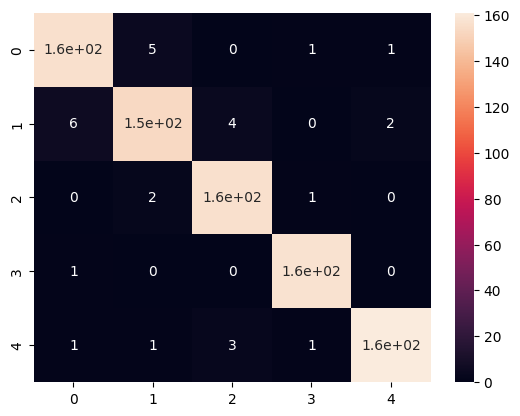

In [ ]:
cm = confusion_matrix(y_test, y_predict)
f = sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       163
           1       0.95      0.93      0.94       165
           2       0.96      0.98      0.97       159
           3       0.98      0.99      0.99       158
           4       0.98      0.96      0.97       167

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812



In [ ]:
classifier.save(save_path + 'Contrastive_npair_resnet50.h5')
classifier.save_weights(save_path1 + "Weights_Contrastive_npair_resnet50.h5")

In [ ]:
npair_VGG16=load_model(save_path + 'Contrastive_npair_resnet50.h5')

In [ ]:
accuracy = npair_VGG16.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

26/26 [==============================] - 2s 33ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9643
Test accuracy: 96.43%


26/26 [==============================] - 2s 29ms/step


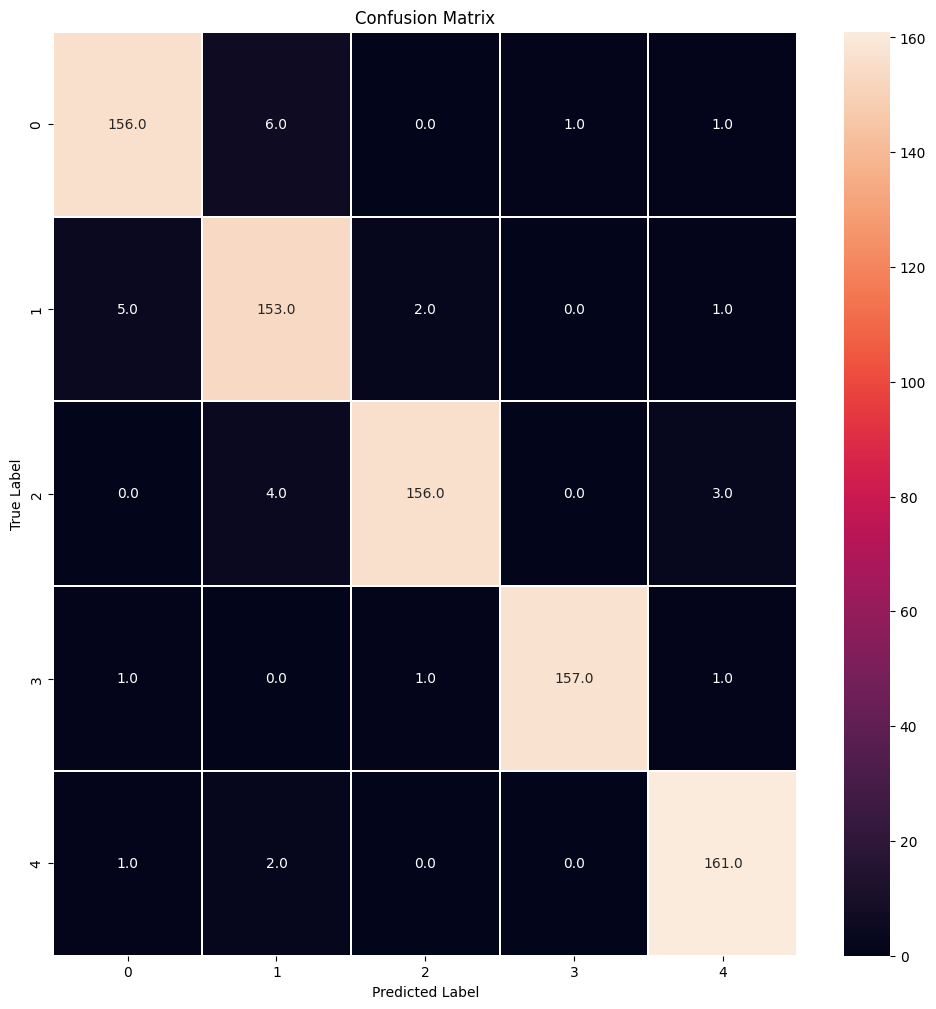

In [ ]:
pred = npair_VGG16.predict(x_test)
cancer_classes=np.unique(y_test)
y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(cancer_classes)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report_npair = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df2 = pd.DataFrame(report_npair).transpose()
df2

,precision,recall,f1-score,support
0,0.951220,0.957055,0.954128,163.000000
1,0.950311,0.927273,0.938650,165.000000
2,0.957055,0.981132,0.968944,159.000000
3,0.981250,0.993671,0.987421,158.000000
4,0.981707,0.964072,0.972810,167.000000
accuracy,0.964286,0.964286,0.964286,0.964286
macro avg,0.964309,0.964641,0.964391,812.000000
weighted avg,0.964291,0.964286,0.964205,812.000000
